In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Load the dataset
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/traffic.csv')

# Convert the DateTime column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

# Ensure data is sorted by DateTime to maintain time sequence
df.sort_values(by='DateTime', inplace=True)

# Set DateTime as the index
df.set_index('DateTime', inplace=True)

# Fit the scaler on the entire dataset (not per junction)
scaler = MinMaxScaler(feature_range=(0, 1))
df['Vehicles'] = scaler.fit_transform(df['Vehicles'].values.reshape(-1, 1))

# Get unique junctions
unique_junctions = df['Junction'].unique()

# Prepare data for LSTM
traffic_data = {}
for junction in unique_junctions:
    traffic_data[junction] = df[df['Junction'] == junction]['Vehicles'].values.reshape(-1, 1)

# Create dataset function
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 24
X_train_list, y_train_list, X_val_list, y_val_list, X_test_list, y_test_list = [], [], [], [], [], []

for junction in unique_junctions:
    data = traffic_data[junction]  # Get scaled data per junction

    train_size = int(len(data) * 0.7)  # 70% train
    val_size = int(len(data) * 0.15)  # 15% validation
    test_size = len(data) - train_size - val_size  # 15% test

    train, val, test = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

    X_train, y_train = create_dataset(train, look_back)
    X_val, y_val = create_dataset(val, look_back)
    X_test, y_test = create_dataset(test, look_back)

    X_train_list.append(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)))
    y_train_list.append(y_train)
    X_val_list.append(np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)))
    y_val_list.append(y_val)
    X_test_list.append(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))
    y_test_list.append(y_test)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Train the model


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
for i in range(len(unique_junctions)):
    model.fit(
        X_train_list[i], y_train_list[i],
        validation_data=(X_val_list[i], y_val_list[i]),
        batch_size=1, epochs=1, callbacks=[early_stopping], verbose=1
    )

10189/10189 ━━━━━━━━━━━━━━━━━━━━ 153s 15ms/step - loss: 0.0019 - val_loss: 0.0015
10189/10189 ━━━━━━━━━━━━━━━━━━━━ 151s 15ms/step - loss: 2.2696e-04 - val_loss: 2.5246e-04
10189/10189 ━━━━━━━━━━━━━━━━━━━━ 151s 15ms/step - loss: 0.0011 - val_loss: 0.0015
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - loss: 1.9861e-04 - val_loss: 1.7316e-04


319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Green Light Plan for Next Hour:
Junction 1: 14.63 seconds
Junction 2: 14.98 seconds
Junction 3: 16.28 seconds
Junction 4: 14.21 seconds


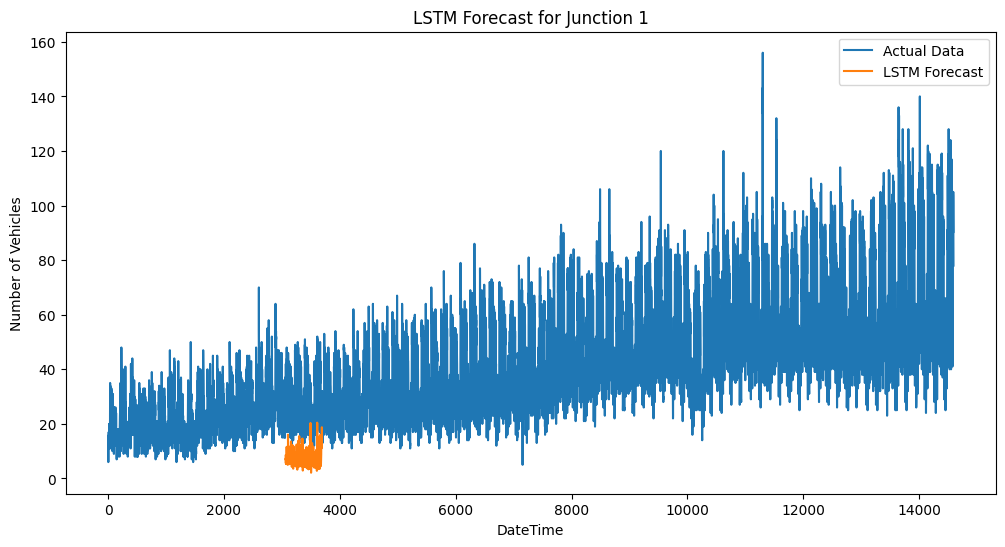

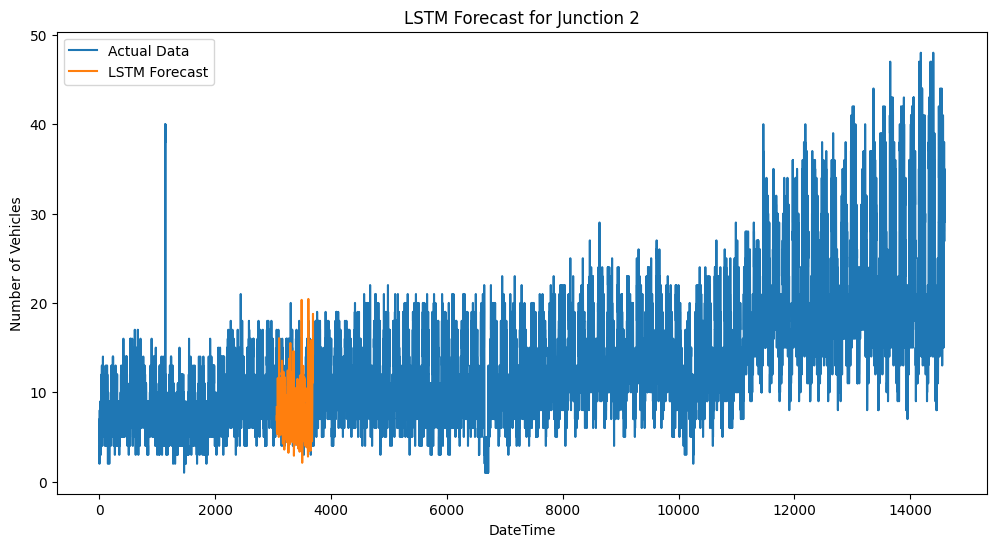

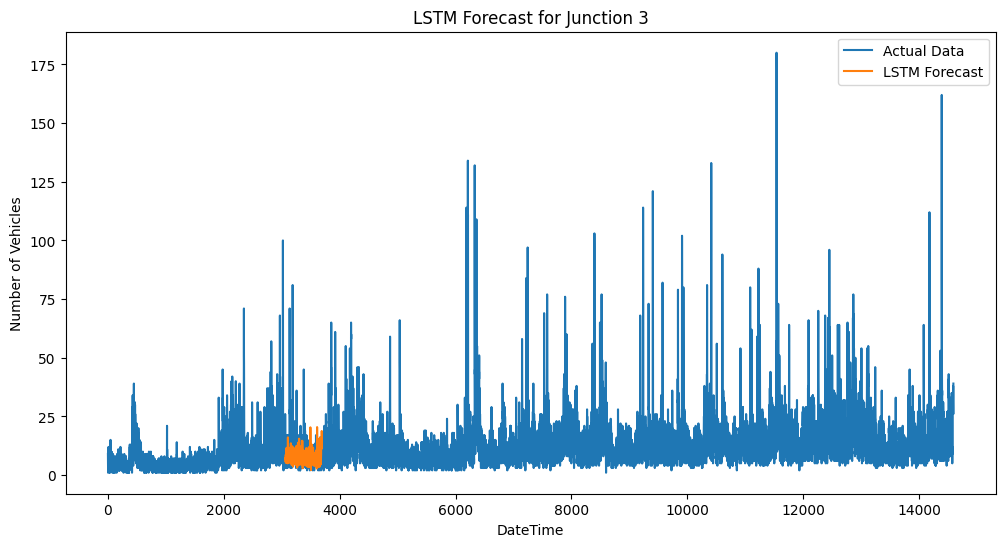

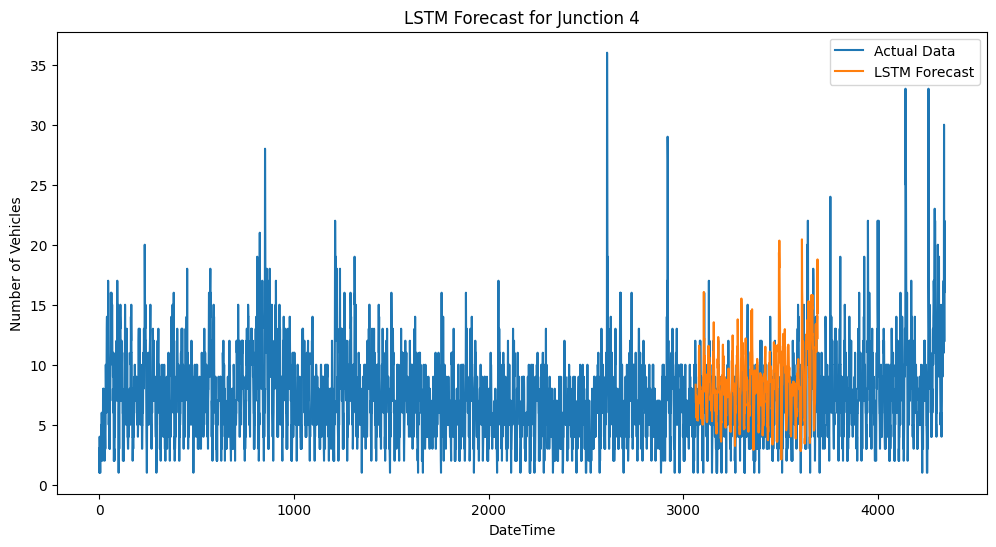

Junction 1:
Train MSE: 400.8964370622804, Train MAE: 17.196143003644348, Train R²: -4.9007251533584375, Train MAPE: 1.0555149063250024
Test MSE: 1311.2154750137786, Test MAE: 32.45946973928403, Test R²: -1.132430346656955, Test MAPE: 0.45189242045956857

Junction 2:
Train MSE: 133.65614679495752, Train MAE: 9.943621106841547, Train R²: -12.41321715261083, Train MAPE: 1.5284505950361134
Test MSE: 60.84695282657008, Test MAE: 6.614188992894549, Test R²: 0.18477461826886465, Test MAPE: 0.251583693205039

Junction 3:
Train MSE: 124.97267671552805, Train MAE: 9.126391162608016, Train R²: -2.6231052889417827, Train MAPE: 2.4487040225344083
Test MSE: 55.6241162697293, Test MAE: 4.287449897959932, Test R²: 0.5330236100136616, Test MAPE: 0.2225289293659076

Junction 4:
Train MSE: 17.535020853036755, Train MAE: 3.3505631711832278, Train R²: -0.5760013309188936, Train MAPE: 0.6229478556018764
Test MSE: 9.497929739836902, Test MAE: 2.170478740695176, Test R²: 0.5148824187714192, Test MAPE: 0.32854

In [13]:
predictions = {}

for i, junction in enumerate(unique_junctions):
    train_predict = model.predict(X_train_list[i])
    test_predict = model.predict(X_test_list[i])
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    predictions[junction] = test_predict

# Calculate green light durations
def calculate_green_time(traffic_count):
    total_traffic = sum(traffic_count)
    if total_traffic == 0:
        return [60] * len(traffic_count)  # Default 60s if no traffic detected
    return [(count / total_traffic) * 60 for count in traffic_count]

latest_predictions = {junction: predictions[junction][-4:].flatten() for junction in unique_junctions}
green_durations = {junction: calculate_green_time(latest_predictions[junction]) for junction in unique_junctions}

print("\nGreen Light Plan for Next Hour:")
for junction, durations in green_durations.items():
    print(f"Junction {junction}: {round(durations[0], 2)} seconds")

# Plot LSTM forecast for each junction
for i, junction in enumerate(unique_junctions):
    df_junction_scaled = traffic_data[junction]
    train_predict_plot = np.empty_like(df_junction_scaled)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[train_size + look_back:train_size + look_back + len(test_predict), :] = test_predict


    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(df_junction_scaled), label='Actual Data')
    plt.plot(train_predict_plot, label='LSTM Forecast')
    plt.title(f'LSTM Forecast for Junction {junction}')
    plt.xlabel('DateTime')
    plt.ylabel('Number of Vehicles')
    plt.legend()
    plt.show()

# Performance evaluation
# Performance evaluation with length consistency
for i, junction in enumerate(unique_junctions):
    y_train_actual = scaler.inverse_transform([y_train_list[i]])
    y_test_actual = scaler.inverse_transform([y_test_list[i]])

    # Ensure the test predictions and actual data have the same length
    min_test_len = min(len(y_test_actual[0]), len(predictions[junction]))
    y_test_trimmed = y_test_actual[0][:min_test_len]
    predictions_trimmed = predictions[junction][:min_test_len]

    # Ensure the train predictions and actual data have the same length
    min_train_len = min(len(y_train_actual[0]), len(predictions[junction]))
    y_train_trimmed = y_train_actual[0][:min_train_len]
    predictions_train_trimmed = predictions[junction][:min_train_len]

    train_mse = mean_squared_error(y_train_trimmed, predictions_train_trimmed)
    test_mse = mean_squared_error(y_test_trimmed, predictions_trimmed)
    train_mae = mean_absolute_error(y_train_trimmed, predictions_train_trimmed)
    test_mae = mean_absolute_error(y_test_trimmed, predictions_trimmed)
    train_r2 = r2_score(y_train_trimmed, predictions_train_trimmed)
    test_r2 = r2_score(y_test_trimmed, predictions_trimmed)
    train_mape = mean_absolute_percentage_error(y_train_trimmed, predictions_train_trimmed)
    test_mape = mean_absolute_percentage_error(y_test_trimmed, predictions_trimmed)

    print(f'Junction {junction}:')
    print(f'Train MSE: {train_mse}, Train MAE: {train_mae}, Train R²: {train_r2}, Train MAPE: {train_mape}')
    print(f'Test MSE: {test_mse}, Test MAE: {test_mae}, Test R²: {test_r2}, Test MAPE: {test_mape}\n')

